In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob

Open a netcdf file and show the size. 

In [62]:
ncfiles = 'b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h2.IVT.1980010100-1989123100.nc'
ds1 = xr.open_mfdataset(ncfiles)
print(f'Variable size: {ds1.nbytes/1e9:.1f} GB')
print('Number of years in one file:', ds1.time.shape[0]/4/365)  # number of years

Variable size: 3.2 GB
Number of years in one file: 10.0


We need to rechunck becuase the file is too large for creating a zarr store.

In [30]:
ds1_ivt = ds1[['IVT']]
ds1_ivt['IVT'] = ds1_ivt['IVT'].astype('float16')
ds1_chunked = ds1_ivt.chunk({'time': 1000, 'lat': 192, 'lon': 288})

Save as a zarr store. 

In [40]:
zarr_store = 'ds.zarr'
ds1_chunked.to_zarr(zarr_store, mode='w')

Open the newly created zarr data and compare with the netcdf file.

In [41]:
ds1_zarr = xr.open_zarr(zarr_store, consolidated=False)
print(f'Variable size: {ds1_zarr.nbytes/1e9:.1f} GB')

Variable size: 1.6 GB


In [6]:
print(ds1_ivt.IVT.sizes)
print(ds1_zarr.IVT.sizes)
print(ds1_ivt.chunks)
print(ds1_zarr.chunks)

Frozen({'time': 14600, 'lat': 192, 'lon': 288})
Frozen({'time': 14600, 'lat': 192, 'lon': 288})
Frozen({'time': (14600,), 'lat': (192,), 'lon': (288,)})
Frozen({'time': (1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 600), 'lat': (192,), 'lon': (288,)})


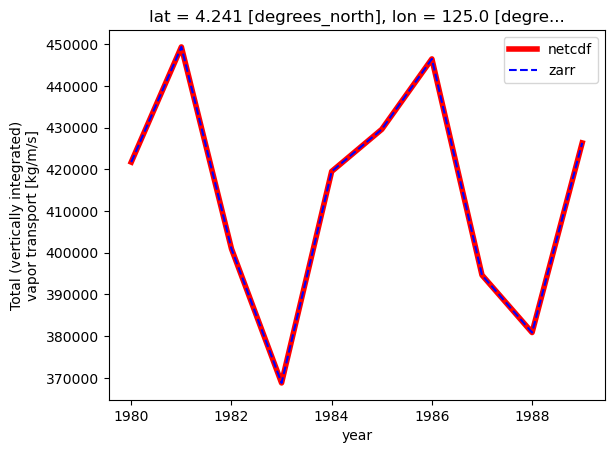

In [7]:
ds1_ivt.IVT.groupby('time.year').sum().isel(lat=100,lon=100).plot(label='netcdf', linewidth='4', color='r')
ds1_zarr.IVT.groupby('time.year').sum().isel(lat=100,lon=100).plot(label='zarr', color='b', linestyle='--')
plt.legend()
plt.show()

Append another netcdf to the zarr store.

In [8]:
ds2 = xr.open_dataset('b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h2.IVT.1990010100-1999123100.nc')
ds2_ivt = ds2[['IVT']]
ds2_chunked = ds2_ivt.chunk({'time': 1000, 'lat': 192, 'lon': 288}) # make sure the chunk size is the same as the first file

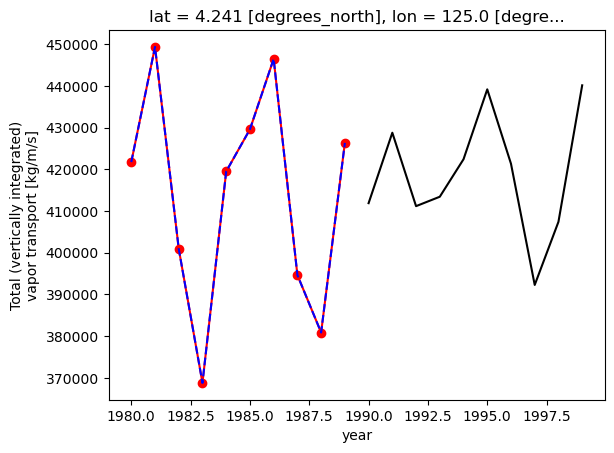

In [10]:
ds1_ivt.IVT.groupby('time.year').sum().isel(lat=100,lon=100).plot(color='r', marker='o')
ds1_zarr.IVT.groupby('time.year').sum().isel(lat=100,lon=100).plot(label='zarr', color='b', linestyle='--')
ds2_chunked.IVT.groupby('time.year').sum().isel(lat=100,lon=100).plot(color='k')

In [11]:
ds2_chunked.to_zarr('ds.zarr', mode='a', append_dim='time')

Open the updated zarr store

In [12]:
ds2_zarr = xr.open_zarr(zarr_store, consolidated=False)
print(f'Variable size: {ds2_zarr.nbytes/1e9:.1f} GB')

Variable size: 6.5 GB


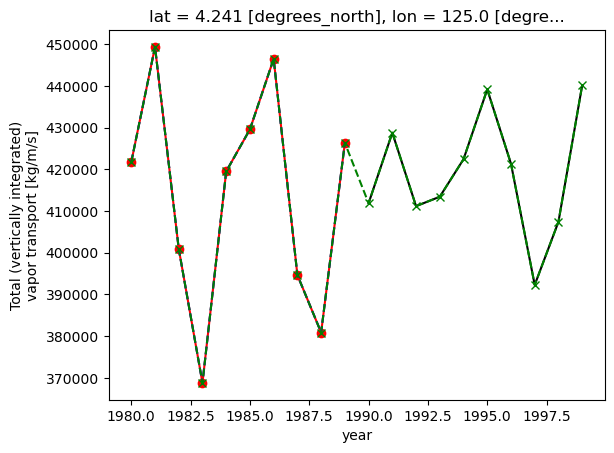

In [13]:
ds1_ivt.IVT.groupby('time.year').sum().isel(lat=100,lon=100).plot(color='r', marker='o')
ds1_zarr.IVT.groupby('time.year').sum().isel(lat=100,lon=100).plot(label='zarr', color='b', linestyle='--')
ds2_chunked.IVT.groupby('time.year').sum().isel(lat=100,lon=100).plot(color='k')
ds2_zarr.IVT.groupby('time.year').sum().isel(lat=100,lon=100).plot(color='g', linestyle='--', marker='x')

Compare the zarr size with the netcdf

In [17]:
ncfiles = glob.glob('b.e21.*19*.nc')
ds_nc = xr.open_mfdataset(ncfiles)
print(f'Variable size: {ds_nc.nbytes/1e9:.1f} GB')

Variable size: 6.6 GB


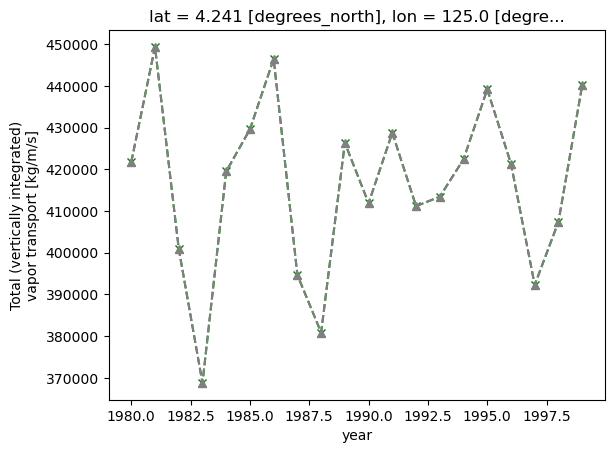

In [18]:
ds2_zarr.IVT.groupby('time.year').sum().isel(lat=100,lon=100).plot(color='g', linestyle='--', marker='x')
ds_nc.IVT.groupby('time.year').sum().isel(lat=100,lon=100).plot(color='gray', linestyle='--', marker='^')

In [19]:
ds2_zarr

<xarray.Dataset>
Dimensions:  (time: 29200, lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1980-01-01 00:00:00 ... 1999-12-31 18:00:00
Data variables:
    IVT      (time, lat, lon) float32 dask.array<chunksize=(1000, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    case:              b.e21.BHISTsmbb.f09_g17.LE2-1011.001
    host:              mom1
    initial_file:      b.e21.B1850.f09_g17.CMIP6-piControl.001.cam.i.1011-01-...
    logname:           sunseon
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    source:            CAM
    time_period_freq:  hour_6
    topography_file:   /mnt/lustre/share/CESM/cesm_input/atm/cam/topo/fv_0.9x...

# TESTS

Reduce the size

In [27]:
ds1.IVT.values[0]

array([[ 6.25309  ,  6.25309  ,  6.25309  , ...,  6.25309  ,  6.25309  ,
         6.25309  ],
       [ 6.8521237,  6.8485336,  6.8434935, ...,  6.8542504,  6.8545766,
         6.853973 ],
       [ 7.2037764,  7.1990447,  7.1911182, ...,  7.1952724,  7.2031355,
         7.205263 ],
       ...,
       [33.031578 , 32.860867 , 32.681034 , ..., 33.47809  , 33.34044  ,
        33.19207  ],
       [27.008846 , 26.97577  , 26.9302   , ..., 27.063717 , 27.055256 ,
        27.035799 ],
       [23.65418  , 23.654167 , 23.654156 , ..., 23.654226 , 23.65421  ,
        23.654194 ]], dtype=float32)

In [63]:
print(f'Variable size: {ds1.nbytes/1e9:.1f} GB')

Variable size: 3.2 GB


In [44]:
ds1['IVT'] = ds1['IVT'].astype('float16')  # Convert to float16
print(f'Variable size: {ds1.nbytes/1e9:.1f} GB')

Variable size: 1.6 GB


In [25]:
ds1.IVT.values[0]

array([[ 6.254,  6.254,  6.254, ...,  6.254,  6.254,  6.254],
       [ 6.85 ,  6.848,  6.844, ...,  6.855,  6.855,  6.855],
       [ 7.203,  7.2  ,  7.19 , ...,  7.195,  7.203,  7.207],
       ...,
       [33.03 , 32.88 , 32.7  , ..., 33.47 , 33.34 , 33.2  ],
       [27.02 , 26.97 , 26.94 , ..., 27.06 , 27.06 , 27.03 ],
       [23.66 , 23.66 , 23.66 , ..., 23.66 , 23.66 , 23.66 ]],
      dtype=float16)

Create a subset

In [64]:
print(f'Variable size: {ds1.nbytes/1e9:.1f} GB')

Variable size: 3.2 GB


In [98]:
ds1_subset = ds1.sel(lat=slice(20, 54.9986), lon=slice(360-130, 360-60.0028)).isel(time=0)
ds1_subset

<xarray.Dataset>
Dimensions:              (lat: 37, lon: 56, lev: 32, ilev: 33, cosp_prs: 7,
                          nbnd: 2, cosp_tau: 7, cosp_scol: 10, cosp_ht: 40,
                          cosp_sr: 15, cosp_sza: 5, cosp_dbze: 15,
                          cosp_htmisr: 16, cosp_tau_modis: 7, cosp_reffice: 6,
                          cosp_reffliq: 6)
Coordinates: (12/16)
  * lat                  (lat) float64 20.26 21.2 22.15 ... 52.3 53.25 54.19
  * lon                  (lon) float64 230.0 231.2 232.5 ... 296.2 297.5 298.8
  * lev                  (lev) float64 3.643 7.595 14.36 ... 957.5 976.3 992.6
  * ilev                 (ilev) float64 2.255 5.032 10.16 ... 967.5 985.1 1e+03
  * cosp_prs             (cosp_prs) float64 9e+04 7.4e+04 ... 2.45e+04 9e+03
  * cosp_tau             (cosp_tau) float64 0.15 0.8 2.45 6.5 16.2 41.5 100.0
    ...                   ...
  * cosp_dbze            (cosp_dbze) float64 -72.5 -42.5 -37.5 ... 17.5 50.0
  * cosp_htmisr          (cosp_htmisr) float64 0.0 250.0 ... 1.6e+04 1.8e+04
  * cosp_tau_modis       (cosp_tau_modis) float64 0.15 0.8 2.45 ... 41.5 100.0
  * cosp_reffice         (cosp_reffice) float64 5e-06 1.5e-05 ... 5e-05 7.5e-05
  * cosp_reffliq         (cosp_reffliq) float64 4e-06 9e-06 ... 1.75e-05 2.5e-05
    time                 object 1980-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/35)
    gw                   (lat) float64 dask.array<chunksize=(37,), meta=np.ndarray>
    hyam                 (lev) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    hybm                 (lev) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    P0                   float64 ...
    hyai                 (ilev) float64 dask.array<chunksize=(33,), meta=np.ndarray>
    hybi                 (ilev) float64 dask.array<chunksize=(33,), meta=np.ndarray>
    ...                   ...
    n2ovmr               float64 dask.array<chunksize=(), meta=np.ndarray>
    f11vmr               float64 dask.array<chunksize=(), meta=np.ndarray>
    f12vmr               float64 dask.array<chunksize=(), meta=np.ndarray>
    sol_tsi              float64 dask.array<chunksize=(), meta=np.ndarray>
    nsteph               int32 dask.array<chunksize=(), meta=np.ndarray>
    IVT                  (lat, lon) float32 dask.array<chunksize=(37, 56), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BHISTsmbb.f09_g17.LE2-1011.001
    logname:           sunseon
    host:              mom1
    initial_file:      b.e21.B1850.f09_g17.CMIP6-piControl.001.cam.i.1011-01-...
    topography_file:   /mnt/lustre/share/CESM/cesm_input/atm/cam/topo/fv_0.9x...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  hour_6

In [99]:
ds1_subset.to_netcdf('nc_test.nc')

Find the boundaries

In [92]:
%pip install s3fs

   ---------------------------------------- 0.0/12.5 MB ? eta -:--:--
   --------------------- ------------------ 6.8/12.5 MB 34.9 MB/s eta 0:00:01
   ---------------------------------------- 12.5/12.5 MB 41.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
Note: you may need to restart the kernel to use updated packages.


In [93]:
import xarray as xr
import fsspec
import numpy as np
import s3fs
import zarr
from dask.distributed import Client

import warnings
warnings.filterwarnings("ignore")

In [94]:
base_url = 's3://noaa-nws-aorc-v1-1-1km'

dataset_years = list(range(2018, 2023))        

s3_out = s3fs.S3FileSystem(anon=True)
fileset = [s3fs.S3Map(
            root=f"s3://{base_url}/{dataset_year}.zarr", s3=s3_out, check=False
        ) for dataset_year in dataset_years]

In [95]:
%%time
nws_aorc = xr.open_mfdataset(fileset, engine='zarr')[["APCP_surface"]]

CPU times: total: 1.84 s
Wall time: 15.8 s


In [107]:
print(nws_aorc.latitude.min().values, nws_aorc.latitude.max().values, nws_aorc.longitude.min().values, nws_aorc.longitude.max().values)

20.0 54.998599999999996 -130.0 -60.002800000056595


In [105]:
nc = xr.open_dataset('nc_test.nc')
print(f'Variable size: {nc.nbytes/1e3:.1f} kB')

Variable size: 14.0 kB
